In [680]:
import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#my code
from raster_sample import *
from profile_map_scanner import *




In [14]:
#send pd dataframe to csv for plotting in arc

creek= "Cache_creek_clip_MChiSegmented_whole_basin.csv"
read_path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/"+creek#+"/" #Set path to data
#Creek name for M_chi segmented files
creek_data = np.genfromtxt((read_path), delimiter=',', skip_header=1, names=['node','row','col','latitude','longitude','chi','elevation','flow_distance','drainage_area','m_chi','b_chi','source_key','basin_key','segmented_elevation'])
#+name])
#+name
creek_data_df = pd.DataFrame(creek_data)
#convert to UTM
creek_data_df = convert_lat_long(creek_data_df)

pd.set_option('display.float_format', lambda x: '%.3f' % x)#remove scientific notation !!!!!
creek_data_df

write_path = '/Users/bmelosh/Documents/ArcGIS/Coast_Ranges/Cache_Creek/'
creek_data_df.to_csv('Cache_creek_m_chi.csv')



In [681]:
#Import the RASTER data
raster_path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/"
raster = gdal.Open(raster_path + "/Cache_creek_clip_HS.bil")#Get raster data
dem = raster.ReadAsArray()

## IMPORT point DATA
creek= "Crack_canyon"
path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/"+creek+"/" #Set path to data
name = creek+"_MChiSegmented.csv" #Set file name
creek_data = np.genfromtxt((path+name), delimiter=',', skip_header=1, names=['node', 'row', 'col', 'latitude', 'longitude', 'chi', 'elevation', 'flow_distance', 'drainage_area', 'm_chi', 'b_chi', 'source_key', 'basin_key', 'segmented_elevation'])


#Create pandas dataframe
creek_data_df = pd.DataFrame(creek_data)

#Create a distance column in pandas dataframe
#distance = creek_data_df['flow_distance'] - creek_data_df['flow_distance'].min()
#creek_data_df['distance'] = distance

#convert the lat long to utm from creek data, chi segmented (only need this if there is no x, y columns)
creek_data_df = convert_lat_long(creek_data_df)



In [678]:
#Create a bokeh plot of the raster
import bokeh.plotting as bp
from bokeh.plotting import figure, show, output_file
from bokeh.layouts import gridplot, column


#pull out the products of raster subsampler
X,Y, array = raster_subsample_xy_generator(raster, creek_data_df)

#Create a bokeh source to use in interactive plots
source=bp.ColumnDataSource(creek_data_df)
color_by_variable('m_chi', source=source) #define color scheme for profiles

#define boundaries of the data
x_range, y_range = define_boundaries(source)
elev_range = define_elevation_boundaries(source)


#Create profile plots 

p = stream_map_raster(array, source, title='Map',x_axis_label='Easting', y_axis_label='Northing')

p2 = profile(elev_range, source, title='Elevation profile', x_axis_label='Distance', y_axis_label='Elevation')

p3 = profile(elev_range, source, x='chi', title='Chi profile', x_axis_label='Chi', y_axis_label='Elevation')


output_file("Profile comparison.html", title="Creek scanner")

plotcol = column(p2, p3)
grid = gridplot([[p, plotcol]])

bp.show(grid)  


NameError: name 'raster_subsample_xy_generator' is not defined

In [587]:

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors



In [686]:
#IMPORT MOVERN FILE WITH ALL THE DIFFERENT CHI VALUES FOR EACH M/N RATIO
creek =  'Perkins_creek'
path = '/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/'+creek+'/'
name = creek+'_movern.csv'
#Import Data
creek_movern_df = pd.read_csv((path+name), delimiter=',', header=0, names=['source_key','basin_key','elevation','m_over_n = 0.1','m_over_n = 0.2','m_over_n = 0.3','m_over_n = 0.4','m_over_n = 0.5','m_over_n = 0.6','m_over_n = 0.7','m_over_n = 0.8'])

creek_movern_df = creek_movern_df.rename(columns={'source_key': 'Tributary'})

#THIS SEPERATES OUT THE TRIBUTARY DATA
#creating dataframe of CHI data for all tributaries
creek_movern_df_tributaries = creek_movern_df[creek_movern_df['Tributary'] != 0]

creek_movern_tributaries_merge = pd.DataFrame()



In [794]:
#THIS LOADS THE MLE DATA FOR EACH M/N VALUE FOR EACH TRIBUTARY 

mle_data_i = []
chiMS = []
chi = []
TributariesMLE = []

#Create array of mn values to iterate through (start_mn, end_mn, number of mn values)
mn_values = [x / 10.0 for x in range(1, 9, 1)]#create a list of floats.


for mn in mn_values: 
    num = mn
    full_name = '%s%s_movernstats_%s_fullstats.csv' % (path2, creek, num)

    name_mle = 'MLE m/n %s' % num
    name_rmse = 'RMSE m/n %s' % num

    mle_data = pd.read_csv(full_name, delimiter=',', header= 0,names=['basin_key', 'reference_source_key', 'test_source_key','MLE','RMSE'])

    mle_data = pd.DataFrame(mle_data)
    mle_data_i.append(mle_data)

    creek_movern_tributaries_merge_i = creek_movern_df_tributaries.merge(mle_data, left_on = "Tributary", right_on = "test_source_key")
            
    creek_movern_tributaries_merge[name_mle] = creek_movern_tributaries_merge_i['MLE']
    creek_movern_tributaries_merge[name_rmse] = creek_movern_tributaries_merge_i['RMSE']
    
    
    TributariesMLE_i = list(creek_movern_tributaries_merge[name_mle])
    
    TributariesMLE.append(TributariesMLE_i)
    
    MLE_array = np.asarray(TributariesMLE)
    this_cmap = plt.cm.Reds
    cNorm  = colors.Normalize(vmin=np.min(MLE_array), vmax=np.max(MLE_array))
    plt.cm.ScalarMappable(norm=cNorm, cmap=this_cmap)
    
    #pull out the chi - elevation data for the tributaries
    a = creek_movern_df[creek_movern_df['Tributary']!=0]
    elevation = a['elevation']
    chi_i = list(a['m_over_n = %s' % num])
    elevation = list(elevation)
    chi.append(chi_i)
    
    #pull out the chi - elevation data for the main stem
    b = creek_movern_df[creek_movern_df['Tributary']==0]
    elevationMS = b['elevation']
    chiMS_i = list(b['m_over_n = %s' % num])
    chiMS.append(chiMS_i)
    
    


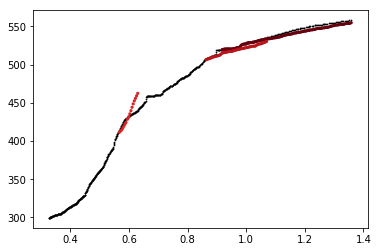

In [728]:
def multiplotter(num):

    plt.scatter(chiMS[num], elevationMS, c='k', s=0.5)
    plt.scatter(chi[num], elevation, c=TributariesMLE[num], cmap=this_cmap, norm=cNorm, s=10, edgecolors='none')

    plt.show()
    
    
multiplotter(5)

##OK this looks like i can do this in mpl now, what about bokeh slider?

In [854]:
###WORKING ON BOKEH PLOTS!!!

In [855]:
import numpy as np

from bokeh.io import curdoc
from bokeh.layouts import column, widgetbox
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import Slider, TextInput
from bokeh.plotting import figure


In [842]:
#Function to import MLE data and create a dataframe with MLE data for all TRIBUTARIES for each M/N Value

creek = "Perkins_creek"
path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/%s/" % creek#Set path to data


#Create a function to pull in MLE data
mn_values = [x / 10.0 for x in range(1, 9, 1)]#create a list of floats.

def create_MLE_data(mn_values):
    TributariesMLE = []
    for mn in mn_values: 
        num = mn
        full_name = '%s%s_movernstats_%s_fullstats.csv' % (path2, creek, num)

        name_mle = 'MLE m/n %s' % num
        name_rmse = 'RMSE m/n %s' % num

        mle_data = pd.read_csv(full_name, delimiter=',', header= 0,names=['basin_key', 'reference_source_key', 'test_source_key','MLE','RMSE'])

        mle_data = pd.DataFrame(mle_data)
        mle_data_i.append(mle_data)

        creek_movern_tributaries_merge_i = creek_movern_df_tributaries.merge(mle_data, left_on = "Tributary", right_on = "test_source_key")

        creek_movern_tributaries_merge[name_mle] = creek_movern_tributaries_merge_i['MLE']
        creek_movern_tributaries_merge[name_rmse] = creek_movern_tributaries_merge_i['RMSE']

        TributariesMLE_i = list(creek_movern_tributaries_merge[name_mle])

        TributariesMLE.append(TributariesMLE_i)

        tributaries_MLE = pd.DataFrame(TributariesMLE)
        tributaries_MLE = tributaries_MLE.transpose()
        tributaries_MLE.rename(columns=lambda x: 'm/n 0.%s' % x, inplace=True)#Name columns

    return tributaries_MLE

In [846]:
#Function to import CHI data for every M/N Value for each Tributary and Main Stem
creek =  'Perkins_creek'
path = '/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/'+creek+'/'
name = creek+'_movern.csv'
    
def import_chi_data(path, creek, name):
    
    #Import Data
    creek_movern_df = pd.read_csv((path+name), delimiter=',', header=0, names=['source_key','basin_key','elevation','m_over_n = 0.1','m_over_n = 0.2','m_over_n = 0.3','m_over_n = 0.4','m_over_n = 0.5','m_over_n = 0.6','m_over_n = 0.7','m_over_n = 0.8'])

    creek_movern_df = creek_movern_df.rename(columns={'source_key': 'Tributary'})
    
    return creek_movern_df

In [867]:
#import chi data
chi_data = import_chi_data(path, creek, name)

#seperate into tribs and main stem
chi = chi_data[chi_data['Tributary'] != 0]
chi_ms = chi_data[chi_data['Tributary'] == 0]

#import mle data
tributaries_MLE = create_MLE_data(mn_values = [x / 10.0 for x in range(1, 9, 1)])

#assign bokeh data sources
chi_source = bp.ColumnDataSource(chi)
chi_ms_source = bp.ColumnDataSource(chi_ms)
mle_source = bp.ColumnDataSource(tributaries_MLE)


# Set up plot
plot = figure(plot_height=250, plot_width=500, title="m/n values",x_axis_label='Chi (X)', y_axis_label='Elevation (m)',
              tools="pan,reset,save,wheel_zoom")
plot.circle('x', 'y', source=chi_source)


# Set up widgets
mn_values_slider = Slider(title="m/n values", value=0.0, start=0.1, end=0.8, step=0.1)


# Set up callbacks
def update_data(attrname, old, new):

    # Get the current slider values
    mn = mn_values_slider.value


    # Generate the new curve
    x = chi_source.data['m_over_n = '%mn]['chi']
    y = chi_source.data['elevation']

    chi_source.data = dict(x=x, y=y)

for mn in [mn_values]:
    mn.on_change('value', update_data)

# Set up layouts and add to document
inputs = widgetbox(mn_values)

curdoc().add_root(column(inputs, plot, width=800))
curdoc().title = "m/n values"


In [866]:
chi_source.data['elevation']

709    554.79
710    554.09
711    553.79
712    553.79
713    553.79
714    553.34
715    552.85
716    552.64
717    552.60
718    552.60
719    552.19
720    551.90
721    551.63
722    551.48
723    551.07
724    550.83
725    550.26
726    549.85
727    549.43
728    548.74
729    548.53
730    548.53
731    548.08
732    548.00
733    547.68
734    547.28
735    547.19
736    547.19
737    547.18
738    546.84
        ...  
874    511.48
875    511.18
876    510.77
877    510.42
878    510.18
879    509.80
880    509.26
881    508.67
882    508.26
883    507.84
884    507.40
885    507.04
886    506.36
887    462.27
888    459.07
889    455.80
890    452.51
891    448.55
892    444.14
893    439.66
894    435.49
895    431.79
896    428.56
897    424.39
898    421.77
899    419.21
900    416.51
901    414.27
902    412.91
903    411.45
Name: elevation, dtype: float64

<bound method Slider.__init__ of Slider(id='a09890aa-8c61-4ef7-8e26-bebd4e424c6a', ...)>